In [30]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from global_model_periodic_energy import LearnedSimulator_periodic

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('high')
normalization_stats = {
    "velocity": {"mean": torch.tensor([0.0, 0.0]).to(device), "std": torch.tensor([1e-3, 1e-3]).to(device)},
    "acceleration": {"mean": torch.tensor([0.0, 0.0]).to(device), "std": torch.tensor([1e0, 1e0]).to(device)}
}

In [32]:
checkpoint = torch.load("/home/jeanlienhard/Documents/Cell_GNN/GNN for energy/Training/Energy_with_perimeter/model_238.pth")
new_state_dict = {k.replace("_orig_mod.", ""): v for k, v in checkpoint.items()}
model = LearnedSimulator_periodic(num_dimensions=2, normalization_stats=normalization_stats, device=device,n_cells = 10)
model.load_state_dict(new_state_dict)
model.to(device)

LearnedSimulator_periodic(
  (graph_network): EnergyGNN(
    (edge_to_node): edgeToNode()
    (gnn_layer1): NodeGNN()
    (gnn_layer2): NodeGNN()
    (gnn_layer3): NodeGNN()
    (gnn_layer4): NodeGNN()
    (gnn_layer5): NodeGNN()
    (regressor): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=1, bias=True)
    )
  )
)

In [33]:
def make_periodic_copies(x_centers):
    x_offset, y_offset = 2.0, 2.0
    copies = [x_centers]
    for gx in range(-2,3):
        for gy in range(-2,3):
            if gx != 0 or gy != 0:
                shift = torch.tensor([gx*x_offset, gy*y_offset], device=x_centers.device)
                copies.append(x_centers + shift)
    x_full = torch.cat(copies, dim=0)
    return x_full.unsqueeze(1)


In [34]:
def get_energy_and_grad_fn(model,energies_list):
    device = next(model.parameters()).device
    def energy_and_grad(x_numpy):
        x = torch.tensor(x_numpy, requires_grad=True, dtype=torch.float32, device=device)
        x_centers = x.view(10,2)
        
        x_full = make_periodic_copies(x_centers)
        E_cell = model(x_full,10)  
        E = E_cell.sum() 
        E.backward()
        grad = x.grad.detach().cpu().numpy()
        energies_list.append(E.item()*1e-4)
        return E.item(), grad
    return energy_and_grad


In [ ]:
df = pd.read_csv("/home/jeanlienhard/Documents/Cell_GNN/Data/raw_data/positions_13.csv") 
x0 = df[df["step"] == 0].iloc[:10][['x', 'y']].values.astype(np.float32).flatten()
energies = []
res = minimize(get_energy_and_grad_fn(model,energies), x0,
               method='L-BFGS-B',
               jac=True,
               options={'maxiter': 100, 'disp': True})

print("Optimized positions :", res.x.reshape(10,2))

/tmp/ipykernel_1113559/621821794.py:4: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  res = minimize(get_energy_and_grad_fn(model,energies), x0,


Optimized positions : [[-0.07002876  0.33707777]
 [ 0.85821042  0.92430801]
 [-1.45176714  0.33790699]
 [ 0.75903013 -0.19535892]
 [-0.77025415 -0.95882685]
 [ 0.01971441  0.71946829]
 [-0.76294881 -0.30813928]
 [ 0.37111408 -0.79419147]
 [-0.32998695 -0.56524252]
 [ 0.08995304 -0.18049493]]


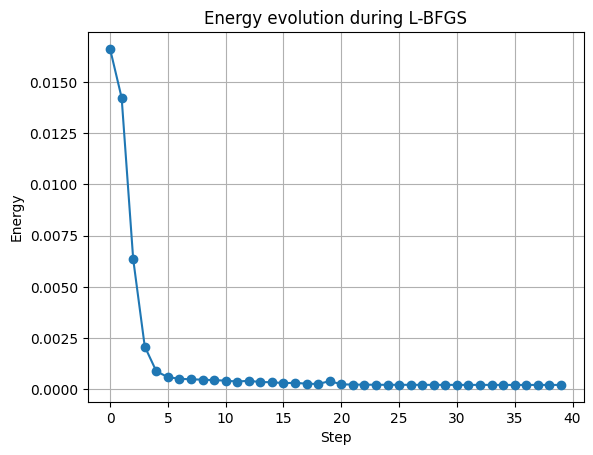

In [36]:
plt.figure()
plt.plot(energies, marker='o')
plt.xlabel('Step')
plt.ylabel('Energy')
plt.title('Energy evolution during L-BFGS')
plt.grid()
plt.show()

In [ ]:
x0_tensor = torch.tensor(x0.reshape(10,2), device=device, dtype=torch.float32)
x0_full = make_periodic_copies(x0_tensor).squeeze(1).detach().cpu().numpy()
df_initial = pd.DataFrame(x0_full, columns=['x','y'])
df_initial.to_csv("initial_positions_periodicity.csv", index=False)


final_x_centers = torch.tensor(res.x.reshape(10,2), dtype=torch.float32, device=device)
final_x_full = make_periodic_copies(final_x_centers)
final_x_full_np = final_x_full.squeeze(1).detach().cpu().numpy() 
df = pd.DataFrame(final_x_full_np, columns=['x', 'y'])
df.to_csv("optimized_positions_periodicity.csv", index=False)